In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

import json
from pprint import pprint
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

sns.set_theme(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})
fontsize = "large"
params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }
plt.rcParams.update(params)

In [2]:
param_names = ["gkbar", "gnabar"]
gkbar_name = param_names[0]
gnabar_name = param_names[1]

with open("../experiments/features.json", "r") as f:
    features = json.load(f)["features"]


def print_nss(df):
    print("number of summary statistics:", len(df.columns[len(param_names) :]))

In [3]:
df_sim = pd.read_csv("../experiments/data/hh_sim_data.csv")
df_sim

,gkbar,gnabar,ADP_peak_amplitude,ADP_peak_values,AHP1_depth_from_peak,AHP2_depth_from_peak,AHP_depth,AHP_depth_abs,AHP_depth_abs_slow,AHP_depth_diff,...,time_to_first_spike,time_to_last_spike,time_to_second_spike,voltage,voltage_after_stim,voltage_base,voltage_deflection,voltage_deflection_begin,voltage_deflection_vb_ssse,ISIs
0,30.884876,126.055551,0.0,-74.773835,115.953543,108.777900,-10.476583,-74.773835,-71.731533,0.024599,...,2.07,83.55,15.89,-54.923639,-58.893479,-64.297252,-3.394341,12.345229,-7.302106,13.580
1,34.317807,116.546381,0.0,-74.870123,114.852623,105.552263,-10.050133,-74.870123,-71.630182,0.035851,...,2.20,75.61,17.11,-56.313478,-52.133721,-64.819989,-9.046716,13.408731,26.413318,14.682
2,44.677952,123.702395,0.0,-75.412290,114.700622,NaN,-9.685345,-75.412290,NaN,NaN,...,2.31,2.31,NaN,-60.660640,-60.906349,-65.726945,4.852015,14.719541,4.871810,NaN
3,38.666067,112.013347,0.0,-75.163555,113.934635,NaN,-9.864657,-75.163555,NaN,NaN,...,2.31,2.31,NaN,-59.983001,-60.249321,-65.298898,5.366203,14.507484,5.022277,NaN
4,36.673347,116.156779,0.0,-74.955514,114.619503,104.092407,-9.880929,-74.955514,-71.680163,0.038792,...,2.24,79.77,17.94,-56.916937,-53.600925,-65.074585,43.450622,13.833981,29.276477,15.506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,44.471203,113.723271,0.0,-75.353260,113.528544,NaN,-9.578084,-75.353260,NaN,NaN,...,2.39,2.39,NaN,-60.770812,-60.986457,-65.775175,4.793198,15.520320,4.800615,NaN
9996,30.344139,118.666283,0.0,-74.687242,115.330857,107.480384,-10.379017,-74.687242,-71.510720,0.027422,...,2.11,84.31,16.06,-54.951131,-59.197091,-64.308225,-4.001270,12.646750,-5.815574,13.700
9997,29.758558,127.173580,0.0,-74.717504,116.091796,109.232532,-10.590675,-74.717504,-71.695892,0.024063,...,2.04,82.26,15.65,-54.773919,-58.102823,-64.126829,-2.027882,12.125165,-6.895878,13.370
9998,32.185860,121.276991,0.0,-74.806404,115.465977,107.486705,-10.286978,-74.806404,-71.674235,0.026723,...,2.12,85.91,16.33,-55.025963,-59.788300,-64.519427,-5.688040,12.789331,1.586447,13.965


In [4]:
print_nss(df_sim)

number of summary statistics: 93


In [8]:
# Count NaNs
pd.set_option("display.max_rows", None)
print(df_sim.isna().sum().to_frame("NaN count"))
pd.set_option("display.max_rows", 50)

                                  NaN count
gkbar                                     0
gnabar                                    0
ADP_peak_amplitude                        0
ADP_peak_values                           0
AHP1_depth_from_peak                      0
AHP2_depth_from_peak                   2569
AHP_depth                                 0
AHP_depth_abs                             0
AHP_depth_abs_slow                     2829
AHP_depth_diff                         2569
AHP_depth_from_peak                       0
AHP_depth_slow                         2829
AHP_slow_time                          2829
AHP_time_from_peak                        0
AP1_amp                                   0
AP1_begin_voltage                         0
AP1_begin_width                           0
AP1_peak                                  0
AP1_width                                 0
AP2_AP1_begin_width_diff               2569
AP2_AP1_diff                           2569
AP2_AP1_peak_diff               

In [9]:
# Drop invalid simulations
print(f"Original size {len(df_sim):,}")

df_sim.dropna(axis=0, inplace=True)

print(f"New size {len(df_sim):,}")

Original size 10,000
New size 7,171


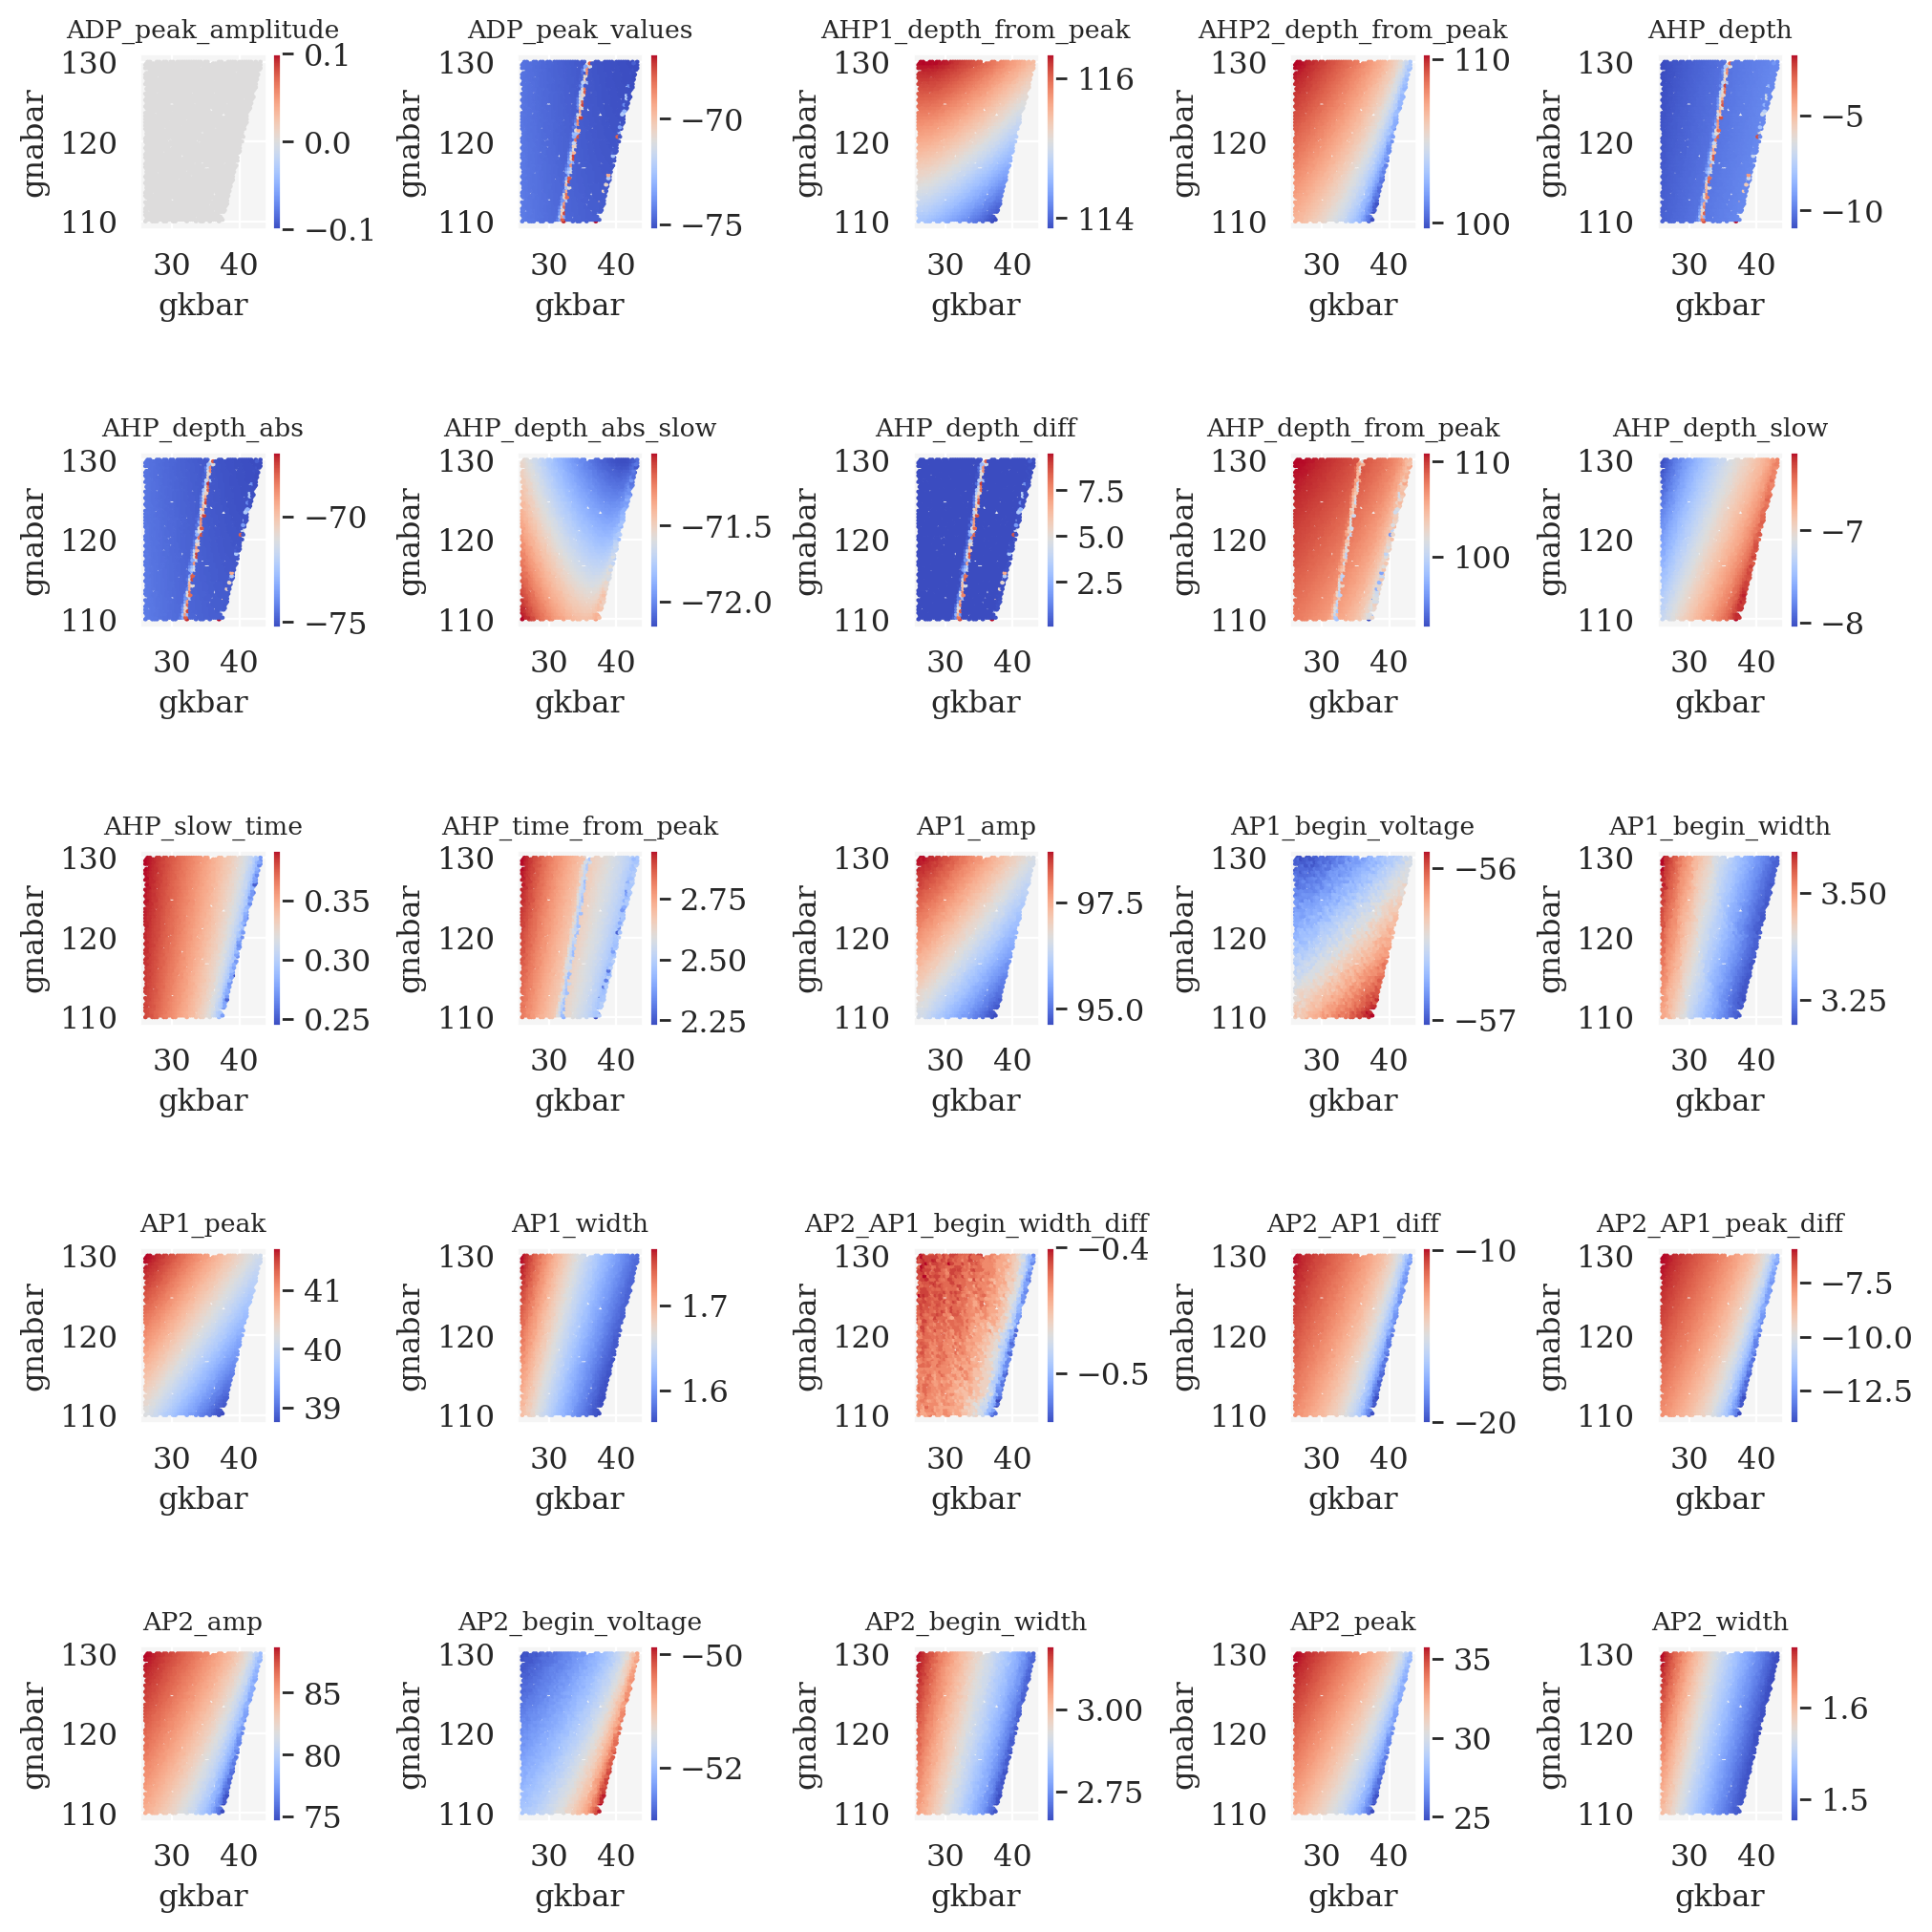

In [10]:
figsize = (10, 10)
dim = 5
gridspec_kw = {"hspace": 0.25, "wspace": 0.05}
gridsize = (50, 50)

fig, axes = plt.subplots(dim, dim, figsize=figsize, constrained_layout=True, gridspec_kw=gridspec_kw)

for i in range(dim**2):
    feature = features[i]
    row_idx = i // dim
    col_idx = i % dim
    axi = axes[row_idx, col_idx]
    hb = axi.hexbin(df_sim[gkbar_name], df_sim[gnabar_name], C=df_sim[feature], gridsize=gridsize, cmap="coolwarm")
    cb = fig.colorbar(hb, ax=axi)

    axi.set(xlabel=gkbar_name, ylabel=gnabar_name, title=feature)
plt.show()

In [11]:
X = df_sim[features].to_numpy()
y = df_sim[param_names].to_numpy()

In [12]:
%time
mi_gkbar = mutual_info_regression(X, y[:, 0])

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 μs


In [13]:
%time
mi_gnabar = mutual_info_regression(X, y[:, 1])

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 3.1 μs


In [14]:
%time
mi_gnabar = mutual_info_regression(X, y[:, 1])

data = {"Feature": features, gkbar_name: mi_gkbar, gnabar_name: mi_gnabar,}
df_mi = pd.DataFrame(data)

df_mi['MI_mean'] = df_mi[[gkbar_name, gnabar_name]].mean(axis=1)
df_mi_sorted = df_mi.sort_values(['MI_mean'], ascending=[False])
df_mi_sorted

CPU times: user 1 μs, sys: 1e+03 ns, total: 2 μs
Wall time: 2.15 μs


,Feature,gkbar,gnabar,MI_mean
66,maximum_voltage_from_voltagebase,1.769731e-01,2.275434e+00,1.226203e+00
40,AP_peak_downstroke,2.151079e+00,2.851543e-01,1.218117e+00
88,voltage_base,2.316985e+00,9.843550e-02,1.207710e+00
72,minimum_voltage,2.074720e+00,1.775667e-01,1.126143e+00
86,voltage,1.788635e+00,3.581983e-01,1.073416e+00
...,...,...,...,...
50,Spikecount,5.616752e-01,0.000000e+00,2.808376e-01
37,AP_fall_rate_change,2.028742e-01,3.164319e-01,2.596530e-01
56,decay_time_constant_after_stim,4.524287e-01,1.244482e-02,2.324367e-01
51,Spikecount_stimint,2.361902e-01,8.848274e-04,1.185375e-01
